In [94]:
### Function Imports
from OptionsFunctions import import_fx_data, plot_forex, daily_returns
import numpy as np
from scipy.stats import norm
import pandas as pd


In [95]:
### Function to Get Most Recent Stock Price (S_0) and Set Strike (K)
def set_price_and_strike(pair, start_date, option_type):
    # Function Call to get FX Data
    forex_data = import_fx_data(pair, start_date) 
    # Get the Spot Price (Most recent FX rate value)
    S_0 = forex_data[pair].iloc[-1]  # Extract the last value from the pair column (ex. 'USDEUR=X')
    # Set Strike Price 2% above (call) or 2% below (put) S_0
    if option_type == 'call':
        K = 1.02*S_0
    elif option_type == 'put':
        K = 0.98*S_0

    return forex_data, S_0, K

### Call Function to Get Most Recent Stock Price and Set Strike
all_forex_pairs = [
        'EURUSD=X', 'GBPUSD=X', 'USDJPY=X', 'USDCHF=X', 'AUDUSD=X', 'NZDUSD=X',
        'USDCAD=X', 'EURGBP=X', 'EURJPY=X', 'EURCHF=X', 'EURAUD=X', 'EURNZD=X',
        'EURCAD=X', 'GBPAUD=X', 'GBPJPY=X', 'GBPCHF=X', 'AUDJPY=X', 'AUDCHF=X',
        'AUDNZD=X', 'NZDJPY=X', 'NZDCHF=X', 'CADJPY=X', 'CADCHF=X', 'CHFJPY=X'
    ]
pair = 'USDEUR=X'
start_date = '2023-07-01'

forex_data, S_0, K = set_price_and_strike(pair, start_date, option_type = 'call')
print(forex_data)
print('The Spot Price is:', round(S_0, 4))
print('The pre-determined Strike Price is:', round(K, 4))


[*********************100%%**********************]  1 of 1 completed

          Date  USDEUR=X
0   2023-07-03   0.91680
1   2023-07-04   0.91633
2   2023-07-05   0.91870
3   2023-07-06   0.92110
4   2023-07-07   0.91822
..         ...       ...
257 2024-06-26   0.93374
258 2024-06-27   0.93632
259 2024-06-28   0.93384
260 2024-07-01   0.93151
261 2024-07-02   0.93130

[262 rows x 2 columns]
The Spot Price is: 0.9313
The pre-determined Strike Price is: 0.9499


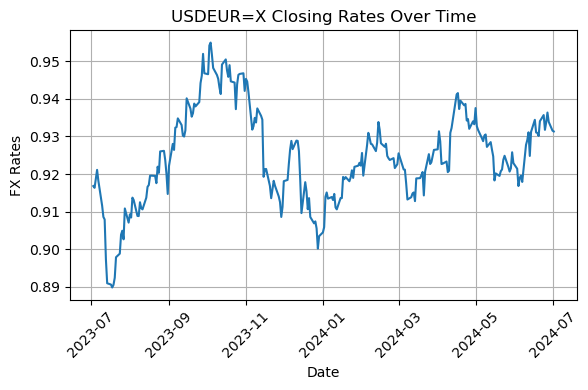

In [96]:
### Call Function to Plot FX Data
plot_pair = ['USDEUR=X']
plot_forex(forex_data, plot_pair)

In [97]:
### Function Call to Compute Daily Returns
daily_rets = daily_returns(forex_data)
print(daily_rets)

# Define the file path where you want to save the CSV
#file_path = 'daily_returns.csv'
# Save the DataFrame to CSV
#daily_rets.to_csv(file_path, index=False)

          Date  USDEUR=X
0   2023-07-04 -0.000513
1   2023-07-05  0.002586
2   2023-07-06  0.002612
3   2023-07-07 -0.003127
4   2023-07-10 -0.007210
..         ...       ...
256 2024-06-26  0.002157
257 2024-06-27  0.002763
258 2024-06-28 -0.002649
259 2024-07-01 -0.002495
260 2024-07-02 -0.000225

[261 rows x 2 columns]


In [98]:
### Function to compute sigma (volatility)
def compute_sigma(returns):
    if 'Date' in returns.columns:
        returns = returns.drop(columns = 'Date')
    # Sigma computation with removed date col
    sigma = np.std(returns) * np.sqrt(252)  # Annualize the volatility
    return sigma.iloc[-1]

sigma = compute_sigma(daily_rets)
print('The sigma value was computed to be:', round(sigma, 5))

The sigma value was computed to be: 0.06188


In [99]:
### Function to Build Black Scholes (BSM) Model
def black_scholes(S_0, K, r, r_f, T, sigma, option_type):
    # Compute d_1 and d_2
    d_1 = (np.log(S_0 / K) + (r - r_f + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    #print(d_1)
    d_2 = d_1 - sigma * np.sqrt(T)
    #print(d_2)
    
    # Compute Option Premium and Greeks
    if option_type == 'call':
        option_price = S_0 * np.exp(-r_f * T) * norm.cdf(d_1) - K * np.exp(-r * T) * norm.cdf(d_2)
        delta = np.exp(-r_f * T) * norm.cdf(d_1)
        theta = (-S_0 * sigma * np.exp(-r_f * T) * norm.pdf(d_1) / (2 * np.sqrt(T)) 
                 - r * K * np.exp(-r * T) * norm.cdf(d_2)
                 + r_f * S_0 * np.exp(-r_f * T) * norm.cdf(d_1))
        rho = K * T * np.exp(-r * T) * norm.cdf(d_2)

    elif option_type == 'put':
        option_price = K * np.exp(-r * T) * norm.cdf(-d_2) - S_0 * np.exp(-r_f * T) * norm.cdf(-d_1)
        delta = -np.exp(-r_f * T) * norm.cdf(-d_1)
        theta = (-S_0 * sigma * np.exp(-r_f * T) * norm.pdf(d_1) / (2 * np.sqrt(T)) 
                 - r * K * np.exp(-r * T) * norm.cdf(-d_2)
                 + r_f * S_0 * np.exp(-r_f * T) * norm.cdf(-d_1))
        rho = -K * T * np.exp(-r * T) * norm.cdf(-d_2)

    else:
        raise ValueError('Error: Incorrect Option Type, must input call or put')

    # Calculate Remaining Greeks
    gamma = np.exp(-r_f * T) * norm.pdf(d_1) / (S_0 * sigma * np.sqrt(T))
    vega = S_0 * np.exp(-r_f * T) * np.sqrt(T) * norm.pdf(d_1)

    # Probabilities
    prob_ITM_call = norm.cdf(d_1)
    prob_ITM_put = norm.cdf(-d_1)
    prob_exercise_call = norm.cdf(d_2)
    prob_exercise_put = norm.cdf(-d_2)

    # Return Option Premium and Greeks
    return option_price, delta, gamma, theta, rho, vega, prob_ITM_call, prob_ITM_put, prob_exercise_call, prob_exercise_put

### Call Function to Compute Option Premium and Greeks
r = 0.02
r_f = 0.01
T = 1
option_type = 'call'
option_price, delta, gamma, theta, rho, vega, prob_ITM_call, prob_ITM_put, prob_exercise_call, prob_exercise_put = black_scholes(S_0, K, r, r_f, T, sigma, option_type)

# Print and explain values
print(f"Option Type: {option_type}")
print(f"Option Price: {option_price:.4f}")
print(f"Delta: {delta:.4f} - Delta represents the sensitivity of the option's price to changes in the underlying asset's price (prob option finishes ITM)")
print(f"Gamma: {gamma:.4f} - Gamma measures the rate of change of Delta with respect to changes in the underlying price.")
print(f"Theta: {theta:.4f} - Theta measures the sensitivity of the option's price to the passage of time.")
print(f"Rho: {rho:.4f} - Rho measures the sensitivity of the option's price to changes in the risk-free interest rate.")
print(f"Vega: {vega:.4f} - Vega measures the sensitivity of the option's price to changes in the volatility of the underlying asset.")
print(f"Probability ITM (Call): {prob_ITM_call:.4f} - Probability the call option finishes In The Money.")
print(f"Probability ITM (Put): {prob_ITM_put:.4f} - Probability the put option finishes In The Money.")
print(f"Probability of Exercise (Call): {prob_exercise_call:.4f} - Probability the call option will be exercised.")
print(f"Probability of Exercise (Put): {prob_exercise_put:.4f} - Probability the put option will be exercised.")


Option Type: call
Option Price: 0.0186
Delta: 0.4448 - Delta represents the sensitivity of the option's price to changes in the underlying asset's price (prob option finishes ITM)
Gamma: 6.7982 - Gamma measures the rate of change of Delta with respect to changes in the underlying price.
Theta: -0.0151 - Theta measures the sensitivity of the option's price to the passage of time.
Rho: 0.3956 - Rho measures the sensitivity of the option's price to changes in the risk-free interest rate.
Vega: 0.3649 - Vega measures the sensitivity of the option's price to changes in the volatility of the underlying asset.
Probability ITM (Call): 0.4493 - Probability the call option finishes In The Money.
Probability ITM (Put): 0.5507 - Probability the put option finishes In The Money.
Probability of Exercise (Call): 0.4249 - Probability the call option will be exercised.
Probability of Exercise (Put): 0.5751 - Probability the put option will be exercised.


In [100]:
### Function to Implement the Hedge (Compute Hedge Position and hedged returns)
def hedge_position(fx_rets, delta, long_pos):
    if 'Date' in fx_rets.columns:
        fx_rets = fx_rets.drop(columns='Date')
    
    hedge_pos = -delta * long_pos
    hedged_rets = fx_rets + hedge_pos
    return hedge_pos, hedged_rets

### Call Hedged Rets Function
long_pos = 1000  # units of currency pair (not dollars)
hedge_pos, hedged_rets = hedge_position(daily_rets, delta, long_pos)
print('The computed hedge position is:', round(hedge_pos, 4))
print("Hedged Returns:")
print(hedged_rets.head())


The computed hedge position is: -444.8127
Hedged Returns:
     USDEUR=X
0 -444.813172
1 -444.810073
2 -444.810047
3 -444.815786
4 -444.819869


In [101]:
### Calculate Hedged/Unhedged Returns
def calculate_hedged_unhedged(pair, long_pos, returns, option_delta):
    # Ensure we're only using the returns data without the Date column
    if 'Date' in returns.columns:
        returns = returns.set_index('Date')
    
    # Select the returns for the specified pair
    pair_returns = returns[pair]

    # Compute daily returns for the long position
    long_rets = pair_returns * long_pos

    # Compute Hedge Position: standard option hedge
    hedge_pos = option_delta * long_pos

    # Compute the returns of the hedged and unhedged positions
    hedged_rets = long_rets - (option_delta * long_pos * pair_returns)
    unhedged_rets = long_rets

    # Compute cumulative returns for the hedged and unhedged positions
    hedged_cumulative_rets = (1 + hedged_rets / long_pos).cumprod() * long_pos
    unhedged_cumulative_rets = (1 + unhedged_rets / long_pos).cumprod() * long_pos

    return hedged_cumulative_rets, unhedged_cumulative_rets

# Assuming 'daily_rets' and 'delta' are already defined
hedged_cumulative_rets, unhedged_cumulative_rets = calculate_hedged_unhedged(pair, long_pos, daily_rets, delta)
print("Hedged Cumulative Returns:")
print(hedged_cumulative_rets.tail())
print("Unhedged Cumulative Returns:")
print(unhedged_cumulative_rets.tail())

Hedged Cumulative Returns:
Date
2024-06-26    1010.709045
2024-06-27    1012.259493
2024-06-28    1010.770941
2024-07-01    1009.370784
2024-07-02    1009.244458
Name: USDEUR=X, dtype: float64
Unhedged Cumulative Returns:
Date
2024-06-26    1018.477309
2024-06-27    1021.291431
2024-06-28    1018.586338
2024-07-01    1016.044883
2024-07-02    1015.815840
Name: USDEUR=X, dtype: float64


In [102]:
### Compute Hedged Returns for All Pairs and Filter to find most Profitable
hedge_ratios_df = pd.DataFrame(columns=['Pair', 'Option Type', 'Option Premium', 'Delta', 'Long Position', 'Short Position', 'Hedged Returns', 'Unhedged Returns'])

for pair in all_forex_pairs:
    try:
        # Assuming the functions 'set_price_and_strike', 'daily_returns', 'black_scholes', 'hedge_position', and 'calculate_hedged_unhedged' are defined elsewhere
        forex_data, S_0, K = set_price_and_strike(pair, start_date, option_type='call')
        daily_rets = daily_returns(forex_data)
        option_price, delta, gamma, theta, rho, vega, prob_ITM_call, prob_ITM_put, prob_exercise_call, prob_exercise_put = black_scholes(S_0, K, r, r_f, T, sigma, option_type='call')
        hedge_pos, hedged_rets = hedge_position(daily_rets, delta, long_pos)
        hedged_cumulative_rets, unhedged_cumulative_rets = calculate_hedged_unhedged(pair, long_pos, daily_rets, delta)

        new_row = pd.DataFrame({
            'Pair': [pair],
            'Option Type': [option_type],
            'Option Premium': [option_price],
            'Delta': [delta],
            'Long Position': [long_pos],
            'Short Position': [hedge_pos],
            'Hedged Returns': [hedged_cumulative_rets.iloc[-1] if not hedged_cumulative_rets.empty else None],
            'Unhedged Returns': [unhedged_cumulative_rets.iloc[-1] if not unhedged_cumulative_rets.empty else None]
        })

        hedge_ratios_df = pd.concat([hedge_ratios_df, new_row], ignore_index=True)

    except Exception as e:
        print(f"Error computing hedge ratio for {pair}: {e}")

# Display the DataFrame
print(hedge_ratios_df.tail())


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

        Pair Option Type  Option Premium     Delta Long Position  \
19  NZDJPY=X        call        1.957669  0.444813          1000   
20  NZDCHF=X        call        0.010942  0.444813          1000   
21  CADJPY=X        call        2.351601  0.444813          1000   
22  CADCHF=X        call        0.013160  0.444813          1000   
23  CHFJPY=X        call        3.575773  0.444813          1000   

    Short Position  Hedged Returns  Unhedged Returns  
19     -444.812659     1058.585046       1106.304185  
20     -444.812659      999.245470        997.485421  
21     -444.812659     1044.294244       1079.656414  
22     -444.812659      986.257465        974.612924  
23     -444.812659     1060.024515       1109.208208  


In [103]:
### Filter for Most Profitable Hedged Pairing
# Sort the DataFrame by the 'Hedged Returns' column in descending order
most_profit_hedged = hedge_ratios_df.sort_values(by = 'Hedged Returns', ascending=False).head(1)
#print(most_profit_hedged)

### Display Results
pair = most_profit_hedged.iloc[0]['Pair']
option_type = most_profit_hedged.iloc[0]['Option Type']
option_premium = most_profit_hedged.iloc[0]['Option Premium']
long_position = most_profit_hedged.iloc[0]['Long Position']
short_position = most_profit_hedged.iloc[0]['Short Position']
hedged_returns = most_profit_hedged.iloc[0]['Hedged Returns']
unhedged_returns = most_profit_hedged.iloc[0]['Unhedged Returns']

print(f"Most Profitable Pairing: {pair}")
print(f"Option Type: {option_type}")
print(f"Option Premium: {option_premium:.6f}")
print(f"Long Position: {long_position}")
print(f"Short Position: {short_position:.6f}")
print("\nReturns:")
print(f"Hedged Returns: {hedged_returns:.6f}")
print(f"Unhedged Returns: {unhedged_returns:.6f}")


Most Profitable Pairing: USDJPY=X
Option Type: call
Option Premium: 3.230233
Long Position: 1000
Short Position: -444.812659

Returns:
Hedged Returns: 1065.469015
Unhedged Returns: 1119.163710
